In [1]:
import numpy as np
import sympy as sym
from scipy.integrate import solve_bvp # solve boundary value problem
from scipy.integrate import solve_ivp # solve initial value problem
from scipy.optimize import minimize
from scipy.linalg import norm
import scipy
import math
pi = math.pi
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import Image
from math import *
from scipy.interpolate import CubicSpline
from numba import jit, prange
from sympy import *

In [2]:
nt = 7
T = 1
dt = T/(nt-1)

In [3]:
x = sym.Symbol('x')
y = sym.Symbol('y')
a, b, c = 1, -2, 0

y = -(a*x**2 + b*x + c)
theta = diff(y,x)
u = diff(theta, x)

xsubs = np.linspace(0, 0+ 2*(-b/(2*a)),nt)

thetasubs = []
# usubs = []
ysubs = []
for i in range(len(xsubs)):
    ysubs.append((y.subs(x, xsubs[i])).evalf())
    thetasubs.append((theta.subs(x, xsubs[i])).evalf())
#     usubs.append((u.subs(x, xsubs[i])).evalf())

##### u should be size one less than theta, x andy y
usubs = np.zeros(nt)
for i in range(nt-1):
    usubs[i] = (thetasubs[i+1] - thetasubs[i])/dt

In [4]:
print('x value', xsubs)
print('y value', ysubs)
print('theta value', thetasubs)
print('u value', usubs)

x value [0.         0.33333333 0.66666667 1.         1.33333333 1.66666667
 2.        ]
y value [0, 0.555555555555556, 0.888888888888889, 1.00000000000000, 0.888888888888889, 0.555555555555556, 0]
theta value [2.00000000000000, 1.33333333333333, 0.666666666666667, 0, -0.666666666666667, -1.33333333333333, -2.00000000000000]
u value [-4. -4. -4. -4. -4. -4.  0.]


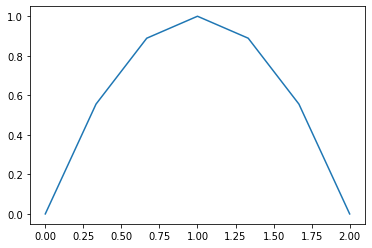

In [5]:
plt.plot(xsubs, ysubs)

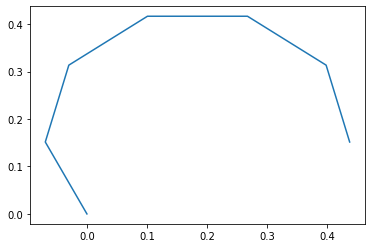

In [6]:
x_sim = np.zeros(len(xsubs))
y_sim = np.zeros(len(ysubs))
theta_sim = np.zeros(len(thetasubs))
for i in range(nt-1):
        if i == 0:
            x_sim[0], y_sim[0], theta_sim[0] = xsubs[0], ysubs[0], thetasubs[0]


        x_sim[i+1] = x_sim[i] +  dt*cos(theta_sim[i])
        y_sim[i+1] = y_sim[i] +  dt*sin(theta_sim[i])
        theta_sim[i+1] = theta_sim[i] + dt*usubs[i]



plt.plot(x_sim, y_sim)

In [7]:
ysubs = np.array(y_sim)
thetasubs = np.array(theta_sim)
usubs = np.array(usubs)
usubs = usubs.reshape((1,nt))
xsubs = xsubs.reshape((1,nt))
ysubs = ysubs.reshape((1,nt))
thetasubs = thetasubs.reshape((1,nt))
state = np.vstack((xsubs,ysubs,thetasubs,usubs))
state_initials = state
print(state_initials.shape)

start_state = state_initials[0:3,0] 
end_state = state_initials[0:3,-1] 


(4, 7)


In [8]:
# @jit(nopython=True)
def cost_function(state_initials, nt, dt):
    state_initials = state_initials.reshape((4,nt))
    u_cost = state_initials[-1,:]
#     u_cost = state_initials[-1,:]
    running_cost = np.zeros((len(u_cost)))
    
    for i in prange(len(u_cost)):
        running_cost[i] = dt*0.5*(u_cost[i])**2
    cost = np.sum(np.square(running_cost))
    return cost

In [11]:
###### constriants from paper

# @jit(nopython=True)
def system_dynamics(state_initials):
    state_initials = state_initials.reshape((4,nt))
    q = state_initials[0:3,:]

    u = state_initials[-1,:]
    u = u.reshape(1,(nt))
    m,n = u.shape
    
#     error = np.zeros( 3*(nt-1) )
    error = np.zeros( 3*(nt) )
    initial_weight, final_weight = 1,1

    for i in range(nt-1):
        error[3*i] = (q[0, i+1] - q[0,i]) - dt*cos(q[2,i])
        error[3*i+1] = (q[1, i+1] - q[1,i]) - dt*sin(q[2,i])
        error[3*i+2] = (q[2, i+1] - q[2,i]) - dt*u[:,i]
    
#     print('before constriants', error)
        
        
    
#     error_bound = np.zeros(3*(nt-1))
#     error_bound = np.zeros(3*(nt))
#     error_bound[0] =  initial_weight*(q[0,0] - start_state[0])
#     error_bound[1] = initial_weight*(q[1,0] - start_state[1])
#     error_bound[2] = initial_weight*(q[2,0] - start_state[2])
    
#     error_bound[-3] = final_weight*(q[0,-1] - end_state[0])
#     error_bound[-2] = final_weight*(q[1,-1] - end_state[1])
#     error_bound[-1] = final_weight*(q[2,-1] - end_state[2])
    error_initial = np.zeros(3)
#     error[0] = error[0] + initial_weight*(q[0,0] - start_state[0])
#     error[1] = error[1] + initial_weight*(q[1,0] - start_state[1])
#     error[2] = error[2] + initial_weight*(q[2,0] - start_state[2])
    error_initial[0] = initial_weight*(q[0,0] - start_state[0])
    error_initial[1] = initial_weight*(q[1,0] - start_state[1])
    error_initial[2] = initial_weight*(q[2,0] - start_state[2])
    
    error[-3] = error[-3] + final_weight*(q[0,-1] - end_state[0])
    error[-2] = error[-2] + final_weight*(q[1,-1] - end_state[1])
    error[-1] = error[-1] + final_weight*(q[2,-1] - end_state[2])
    
#     print('after constriants', error)
#     print('--------------------------------------')
    error_all = np.concatenate((error_initial, error), axis = None)
    
    
    
#     print(error)
    
#     error_all = np.concatenate((error, error_bound), axis = None)
#     error_all = error + error_bound
#     print(error_all)
#     print('----------------------------------')

    
        
        
#     error[-6] = inital_weight*(q[0,0] - start_state[0])
#     error[-5] = inital_weight*(q[1,0] - start_state[1])
#     error[-4] = inital_weight*(q[2,0] - start_state[2])
         
#     error[-6] = inital_weight*(q[0,0] - 0)
#     error[-5] = inital_weight*(q[1,0] - 0)
#     error[-4] = inital_weight*(q[2,0] - 0)
    
#     error[-3] = final_weight*(q[0,-1] - end_state[0])
#     error[-2] = final_weight*(q[1,-1] - end_state[1])
#     error[-1] = final_weight*(q[2,-1] - end_state[2])
#     print('error', error)
#     print('------------------------------')
    
#     return np.sum(error_all*error_all)
    return error_all

In [12]:
######################
#optimazation
from time import time

con = ({'type': 'eq', 'fun': system_dynamics})

tic = time()
sol = minimize(cost_function, state, args=(nt, dt), method='slsqp', jac=None, hess=None, hessp=None, bounds=None, constraints=con, tol=1e-9, callback=None, options={'disp':True, 'maxiter': 300})
elasped_time = time() - tic
print("elasped_time: ", elasped_time)
opt = sol.x.reshape((4,nt))

Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 300
            Function evaluations: 11804
            Gradient evaluations: 300
elasped_time:  48.05287027359009


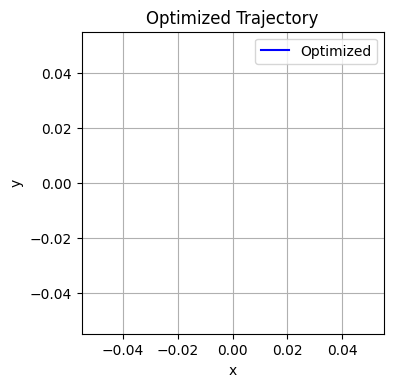

[[nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan]]


In [17]:
plt.figure(dpi=100,facecolor='w')
plt.plot(opt[0,:],opt[1,:], color = 'b', label = "Optimized")

#plt.plot(xsubs, ysubs, label = "subs")
plt.title('Optimized Trajectory')
plt.gca().set_aspect('equal', adjustable='box')
# plt.axvline(np.median(x_check), color='g', label='axvline - full height')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()
print(opt)